# Support Vector Classifier analysis

I rewrote the previous notebook in order include classification for all locations.
I train all the locations seperatly. For each location, I generate a model, do a fitting and predict according to the data.
The are two different kinds of data that we can get, according to the location. The first one is the badly behaved. It corresponds to the locations where we JUST have features with  ice or no ice, and very NO features for the opposite case. The second case is the well behaved data. This corresponds to the location where we can either have ice or not

In array-laguage, the badly behaved case (Case 1) is where training features have JUST '0'/'1'. The well behaved case (Case 2) is the case where training features have '0' and '1'. 

This requires two different kinds of classifiers. 
- For case 1: I use a One-Class SVM. Typically, the SVM algorithm is given a set of training examples labeled as belonging to one of two classes. An SVM model is based on dividing the training sample points into separate categories by as wide a gap as possible, while penalizing training samples that fall on the wrong side of the gap (have just '0's or '1's. The SVM model then makes predictions by assigning points to one side of the gap or the other. Therefore, in one-class SVM, the support vector model is trained on data that has only one class, which is the “normal” class. It infers the properties of normal cases and from these properties can predict which examples are unlike the normal examples. This is useful for anomaly detection because the scarcity of training examples is what defines anomalies: that is, typically there are very few examples of the network intrusion, fraud, or other anomalous behavior. I use a linear kernel, and the reason for this is explained below

- For case 2: I use Linear Support Vector Classifier. This uses a linear kernel and a few other parameters for better fitting. I tried other kernels ('rbf', 'sigmoid' or 'poly') and algorithms (Nu-SVC, C-SVC) and they all give worst results. It is imortant to notice something. In general, all algorithms drop the error to 0 for sufficiently many shuffles. This is because for each location, we can actually find the good shuffle that trains the algorithm perfectly for our testing data. The LinearSVC is that gives error 0 using the least amount of shuffles

In [1]:
# Import required packages
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display, Math #


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.svm import LinearSVC, NuSVC, SVC, OneClassSVM

In [2]:
PT_data = pd.read_excel("PTResults_ice.xlsx")
M = 1000 # number of shuffles
test = 0.15 # test size in percentage

Before training we shuffle the data and split it for $M$ shuffles. We may not have the need to use the sets, but we are sure that when we compare algotirhtms we do it with the same sets.

In [3]:
## Storing suffles  ##

X = PT_data.iloc[:,0:5]
y = PT_data.iloc[:,5:-1]

y_columns = y
y_headers = y_columns.columns.values.tolist()
number_loc = len(y_headers)

training_features_vector = [[] for i in range(M)]
testing_features_vector = [[] for i in range(M)]
training_target_vector = [[] for i in range(M)]
testing_target_vector = [[] for i in range(M)]


#Splitting the data into training and testing and storing to reuze same seeds
# for the different algorithms
if M > 100: print('Start storing...it may take a while to get to ' + str(M) + ' shuffles')
for shuffle in range(M):
    if shuffle%100==0: print('       - storing shuffle ' + str(shuffle))
    for loc in y_headers:

        #Splitting the data into training and testing
        training_features, testing_features, training_target, testing_target = train_test_split(
            X, y[loc], test_size=test, shuffle=True)

        #store
        training_features_vector[shuffle].append(training_features)
        testing_features_vector[shuffle].append(testing_features)
        training_target_vector[shuffle].append(training_target)
        testing_target_vector[shuffle].append(testing_target)  

Start storing...it may take a while to get to 1000 shuffles
       - storing shuffle 0
       - storing shuffle 100
       - storing shuffle 200
       - storing shuffle 300
       - storing shuffle 400
       - storing shuffle 500
       - storing shuffle 600
       - storing shuffle 700
       - storing shuffle 800
       - storing shuffle 900


Now we finaly train our data. We do this for each location seperatly. We go through all locations before changing to the next shuffle. If the error between the prediction and the testing target is zero for a given location, then we don't train the model for this location anymore. If the error is not zero, another model is initiated and trained with a new shuffle.

In [4]:
#Training with Linear SVC


MSE = np.ones(number_loc)
for shuffle in range(M):
    if shuffle%100==0:
        print('Train shuffle ' + str(shuffle))
    
    # End the loop. Vector of error is null. This algorithms works!
    if np.sum(MSE) == 0:
        print('Number of necessary shuffles needed for correct classification: '\
              + str(shuffle))
        break
        
        
    for i_loc in range(number_loc):
        loc = y_headers[i_loc] # get column label for this location
        
        if MSE[i_loc]==0:
            continue # this saves time. Locations with no error are passed
        else:
            
            # retrieving the training/testing sets 
            training_features = training_features_vector[shuffle][i_loc]
            testing_features = testing_features_vector[shuffle][i_loc]
            training_target = training_target_vector[shuffle][i_loc]
            testing_target = testing_target_vector[shuffle][i_loc]
            
            #Case 1: training vector has just ones of zeros
            if np.sum(np.asarray(training_target)) in [len(training_target),0]:
                model = OneClassSVM(nu=0.001, kernel="linear", gamma=0.001)
                model.fit(training_features, training_target)
                #Comparing prediction with testing values
                prediction = model.predict(testing_features)

                #Get means and std
                mse = mean_squared_error(prediction, testing_target)
                
            #Case 2: training ordinary training vectors
            else:
                #Initiate model and fit
                model = LinearSVC(random_state=0, tol=1e-5)
                model.fit(training_features, training_target)
                #Comparing prediction with testing values
                prediction = model.predict(testing_features)

                #Get means and std
                mse = mean_squared_error(prediction, testing_target)
                
            #Update error vector if better model was found
            if mse < MSE[i_loc]:
                MSE[i_loc] = mse

#Just to confirm 
print('MSE: ' + str(MSE))
print('sum of MSE vector ' + str(np.sum(MSE)))

Train shuffle 0
Train shuffle 100
Number of necessary shuffles needed for correct classification: 144
MSE: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
sum of MSE vector 0.0


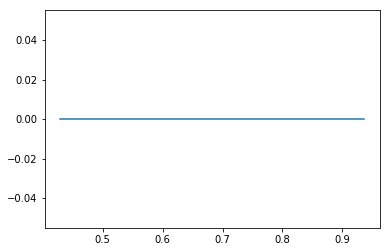

In [5]:
plt.plot(y_headers, MSE)
plt.show()

This is the same thing as below but with different algorithms: Nu-SVC and C-SVC. They are equivelent and is it possible to change to other kernels. Try to change to the kernels 'rbf', 'poly', 'sigmoid' to see what happens...

#### $\nu$-SVC

In [6]:
MSE = np.ones(number_loc)
for shuffle in range(M):
    if shuffle%100==0:
        print('Train shuffle ' + str(shuffle))
    if np.sum(MSE) == 0:
        print('Number of necessary shuffles needed for correct classification: '\
              + str(shuffle))
        break
    for i_loc in range(number_loc):
        loc = y_headers[i_loc] # get column label for this location
        
        if MSE[i_loc]==0:
            continue # this saves time. Locations with no error are passed
        else:
            training_features = training_features_vector[shuffle][i_loc]
            testing_features = testing_features_vector[shuffle][i_loc]
            training_target = training_target_vector[shuffle][i_loc]
            testing_target = testing_target_vector[shuffle][i_loc]
            if np.sum(np.asarray(training_target)) in [len(training_target),0]:
                model = OneClassSVM(nu=0.001, kernel="linear", gamma=0.001)
                model.fit(training_features, training_target)
                prediction = model.predict(testing_features)
                mse = mean_squared_error(prediction, testing_target)
            else:
                # nu must be low - turns out its too low...
                model = NuSVC(nu = 0.001, kernel = 'linear', degree=1, gamma=0.001)  
                model.fit(training_features, training_target)
                prediction = model.predict(testing_features)
                mse = mean_squared_error(prediction, testing_target)
            if mse < MSE[i_loc]:
                MSE[i_loc] = mse
print('MSE: ' + str(MSE))
print('sum of MSE vector ' + str(np.sum(MSE)))

Train shuffle 0
Train shuffle 100
Train shuffle 200
Train shuffle 300
Train shuffle 400
Train shuffle 500
Train shuffle 600
Train shuffle 700
Train shuffle 800
Train shuffle 900
MSE: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.       

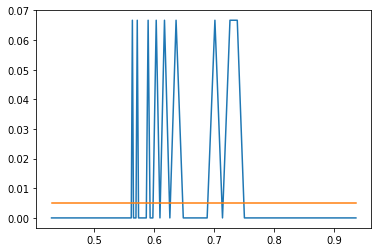

In [7]:
plt.plot(y_headers, MSE, y_headers, np.ones(len(MSE))*np.mean(MSE))
plt.show()

#### C-SVC

Try kernel='linear' or 'poly' and compare with LinearSVC. Sometimes its better...

In [8]:
MSE = np.ones(number_loc)
for shuffle in range(M):
    if shuffle%100==0:
        print('Train shuffle ' + str(shuffle))
    if np.sum(MSE) == 0:
        print('Number of necessary shuffles needed for correct classification: '\
              + str(shuffle))
        break
    for i_loc in range(number_loc):
        loc = y_headers[i_loc] # get column label for this location
        
        if MSE[i_loc]==0:
            continue # this saves time. Locations with no error are passed
        else:
            training_features = training_features_vector[shuffle][i_loc]
            testing_features = testing_features_vector[shuffle][i_loc]
            training_target = training_target_vector[shuffle][i_loc]
            testing_target = testing_target_vector[shuffle][i_loc]
            if np.sum(np.asarray(training_target)) in [len(training_target),0]:
                # change the kernel!!! see what happens!!
                model = OneClassSVM(nu=0.001, kernel="linear", gamma=0.001) 
                model.fit(training_features, training_target)
                prediction = model.predict(testing_features)
                mse = mean_squared_error(prediction, testing_target)
            else:
                # change the kernel!!! see what happens!!
                # nu must be low
                model = SVC(kernel='poly', degree=2, gamma=0.001) 
                model.fit(training_features, training_target)
                prediction = model.predict(testing_features)
                mse = mean_squared_error(prediction, testing_target)
            if mse < MSE[i_loc]:
                MSE[i_loc] = mse
print('MSE: ' + str(MSE))
print('sum of MSE vector ' + str(np.sum(MSE)))


Train shuffle 0
Train shuffle 100
Number of necessary shuffles needed for correct classification: 105
MSE: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
sum of MSE vector 0.0
